
## Integrantes del Grupo:



|**Integrantes**                            | **Correo** |
|------------------------------------------|---------------------------------------------------------------------------------------------------|
|Juan Esteban López Cardona | juanes1793@gmail.com                |
|Nelson Ferrucho  González | nelson.ferrucho@gmail.com              |
|Andres Camilo Rodriguez Patarroyo |acamro@gmail.com                |


## **Proyecto Series de Tiempo para la predicción en la demanda de una microrred**


### Nota: Este notebok se corrió en google colab por facilidad y para un entrenamiento más rápido ya que se utilizo una T4 GPU para agilizar el entrenamiento de los modelos

## Entrenamiento del modelo

In [4]:
import pandas as pd

# Cargamos el df
url = "https://raw.githubusercontent.com/Juanes1793/Proyectos-Data-Science/main/Base_datos/DemandCharge.csv"
#df = pd.read_csv("DemandCharge.csv")
df = pd.read_csv(url)

#Extraemos sólo la información importante
df_forecast = df[["DateTime","TotalCampusLoad"]]
#Se eliminan los datos repetidos en base a la columna "DateTime" conservando el último valor
df_forecast.drop_duplicates(subset='DateTime', keep='last', inplace=True)

<ipython-input-4-8912f2d2b90d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_forecast.drop_duplicates(subset='DateTime', keep='last', inplace=True)


Organizamos el dataset para que quede ordenado por fecha

In [5]:
df_forecast_sorted = df_forecast.copy()
df_forecast_sorted.rename(columns = {'TotalCampusLoad	':'Consumo'}, inplace = True)                    #Se cambia el nombre de serie 1 a Total personas por Día para tene rmás clairdad
df_forecast_sorted['DateTime'] = pd.to_datetime(df_forecast_sorted.DateTime).dt.tz_localize(None)          # Revisar  #Se convierte la columba DateTime a formato fecha sin el formato UTC
df_forecast_sorted.sort_values(by=['DateTime'], axis=0, ascending=True, inplace=True)       #Se ordenan los datos
df_forecast_sorted.reset_index(inplace=True, drop=True)
df_forecast_sorted

,DateTime,TotalCampusLoad
0,2018-01-01 00:00:00,28947.06
1,2018-01-01 00:15:00,28779.14
2,2018-01-01 00:30:00,28737.36
3,2018-01-01 00:45:00,28700.43
4,2018-01-01 01:00:00,28648.00
...,...,...
75827,2020-02-29 22:45:00,31552.81
75828,2020-02-29 23:00:00,31364.09
75829,2020-02-29 23:15:00,31236.65
75830,2020-02-29 23:30:00,31096.75


## Realizamos el entrenamiento del primer modelo . Modelo GRU que  hace parte de modelos LSTM

In [6]:
# importamos librerías

# univariate multi-step encoder-decoder lstm example
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import datetime

from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import GRU

In [7]:
demanda_lista = df_forecast_sorted["TotalCampusLoad"].tolist()
n_steps_in, n_steps_out = 96, 1																# Se usa 96 porque es el número de datos por día que se obtienen cada 15 minutos de la microrred

# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)

	return array(X), array(y)

## **1. Particion del conjunto de datos**
---

Si el dataset no tiene por defecto definida una partición en conjuntos de entrenamiento y prueba, hágala usted, en las proporciones que considere oportunas.

Este código realiza la preparación de datos para entrenar un modelo de series temporales usando una serie de demanda histórica.

- División de secuencia: La función split_sequence() divide la serie de demanda (demanda_lista) en secuencias de entrada y salida usando n_steps_in y n_steps_out como ventanas de tiempo.

- Escalado de datos: Utiliza MinMaxScaler para normalizar los datos de entrada (X) y salida (y) al rango (0, 1), lo cual facilita la convergencia del modelo y reduce la influencia de valores extremos.

- Redimensionamiento:

    n_features se define como 1, ya que se trata de una serie univariada.
    Las secuencias escaladas X_scaled y y_scaled se redimensionan para que el modelo de redes neuronales pueda procesarlas, en un formato 3D (muestras, pasos de tiempo, características).

In [8]:
X, y = split_sequence(demanda_lista,n_steps_in,n_steps_out)                # Se aplica la función teniendo en cuenta los datos de la demanda y el número de pasos, en este caso 96

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)
y = y.reshape(-1,1)
y_scaled = scaler.fit_transform(y)

n_features = 1                                              # Se asigna 1 porque estamos trabajando con una serie univariada
X_scaled = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], n_features))         # Se redimensiona el arreglo dependiendo del número de características de este y condiciones iniciales
y_scaled = y_scaled.reshape((y_scaled.shape[0], y_scaled.shape[1], n_features))

Se reparten los datos en entrenamiento y prueba.80% para prueba y 20% para entrenamiento

In [9]:
X_train,y_train = X_scaled[:60670],y_scaled[:60670]                        # Datos de entrenamiento
X_test,y_test = X_scaled[60670:],y_scaled[60670:]                          # Datos de prueba

## **Se define el modelo**

El uso de una red GRU (Gated Recurrent Unit) es apropiado para datos de series temporales, donde es necesario aprender dependencias a lo largo del tiempo

Dado que estamos prediciendo un valor continuo (demanda), el problema es de regresión. La elección de la función de pérdida mean_absolute_error es adecuada para esta tarea, ya que optimiza el modelo en torno a la minimización del error promedio absoluto en la predicción.

Nuestro diseño de modelo GRU para series de tiempo contiene lo siguiente:

- Capas recurrentes: Las capas GRU se configuran para capturar la secuencia de datos de entrada y pueden aprender dependencias a corto y largo plazo en las series de tiempo.

- Capa de repetición: RepeatVector permite duplicar la salida de la primera GRU para que pueda ser interpretada en el siguiente nivel recurrente. Esto es útil para ajustar las salidas intermedias a las dimensiones necesarias de la salida final.
- Capa final densa: TimeDistributed(Dense(1)) asegura que cada paso de tiempo tenga una salida continua en el mismo rango y dimensión.
- Capas adicionales GRU: Las capas adicionales GRU agregadas en modo return_sequences=True permiten un mayor aprendizaje de patrones temporales al dar al modelo mayor capacidad de representación.

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, RepeatVector, TimeDistributed, Dense, Dropout, BatchNormalization

model = Sequential()
model.add(GRU(100, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(BatchNormalization())  # Normalización de la capa
model.add(Dropout(0.2))  # Regularización para evitar el sobreajuste

model.add(RepeatVector(n_steps_out))

# Capa recurrente intermedia
model.add(GRU(100, activation='relu', return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(GRU(100, activation='relu', return_sequences=True))  # Línea de código adicional
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(GRU(100, activation='relu', return_sequences=True))  # Línea de código adicional
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Capa de salida
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mean_absolute_error')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



- BatchNormalization: Añade normalización para estabilizar las activaciones en cada capa y acelerar la convergencia.

- Dropout: Apaga un porcentaje aleatorio de unidades en cada paso de entrenamiento (20% en este caso), mejorando la generalización del modelo y ayudando a prevenir el sobreajuste.


In [11]:
# Usamso un early stopper
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [12]:
history = model.fit(X_scaled, y_scaled, epochs=100, batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stopping])

Epoch 1/100
1894/1894 ━━━━━━━━━━━━━━━━━━━━ 43s 16ms/step - loss: 0.3171 - val_loss: 0.0293
Epoch 2/100
1894/1894 ━━━━━━━━━━━━━━━━━━━━ 27s 12ms/step - loss: 0.0368 - val_loss: 0.0228
Epoch 3/100
1894/1894 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - loss: 0.0351 - val_loss: 0.0120
Epoch 4/100
1894/1894 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - loss: 0.0333 - val_loss: 0.0251
Epoch 5/100
1894/1894 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - loss: 0.0310 - val_loss: 0.0159
Epoch 6/100
1894/1894 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - loss: 0.0301 - val_loss: 0.0298
Epoch 7/100
1894/1894 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - loss: 0.0290 - val_loss: 0.0414
Epoch 8/100
1894/1894 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - loss: 0.0284 - val_loss: 0.0271
Epoch 9/100
1894/1894 ━━━━━━━━━━━━━━━━━━━━ 40s 12ms/step - loss: 0.0274 - val_loss: 0.0261
Epoch 10/100
1894/1894 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - loss: 0.0271 - val_loss: 0.0327
Epoch 11/100
1894/1894 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - loss: 0.0269 - val_loss: 0.01

In [13]:
print(history.history.keys())

dict_keys(['loss', 'val_loss'])


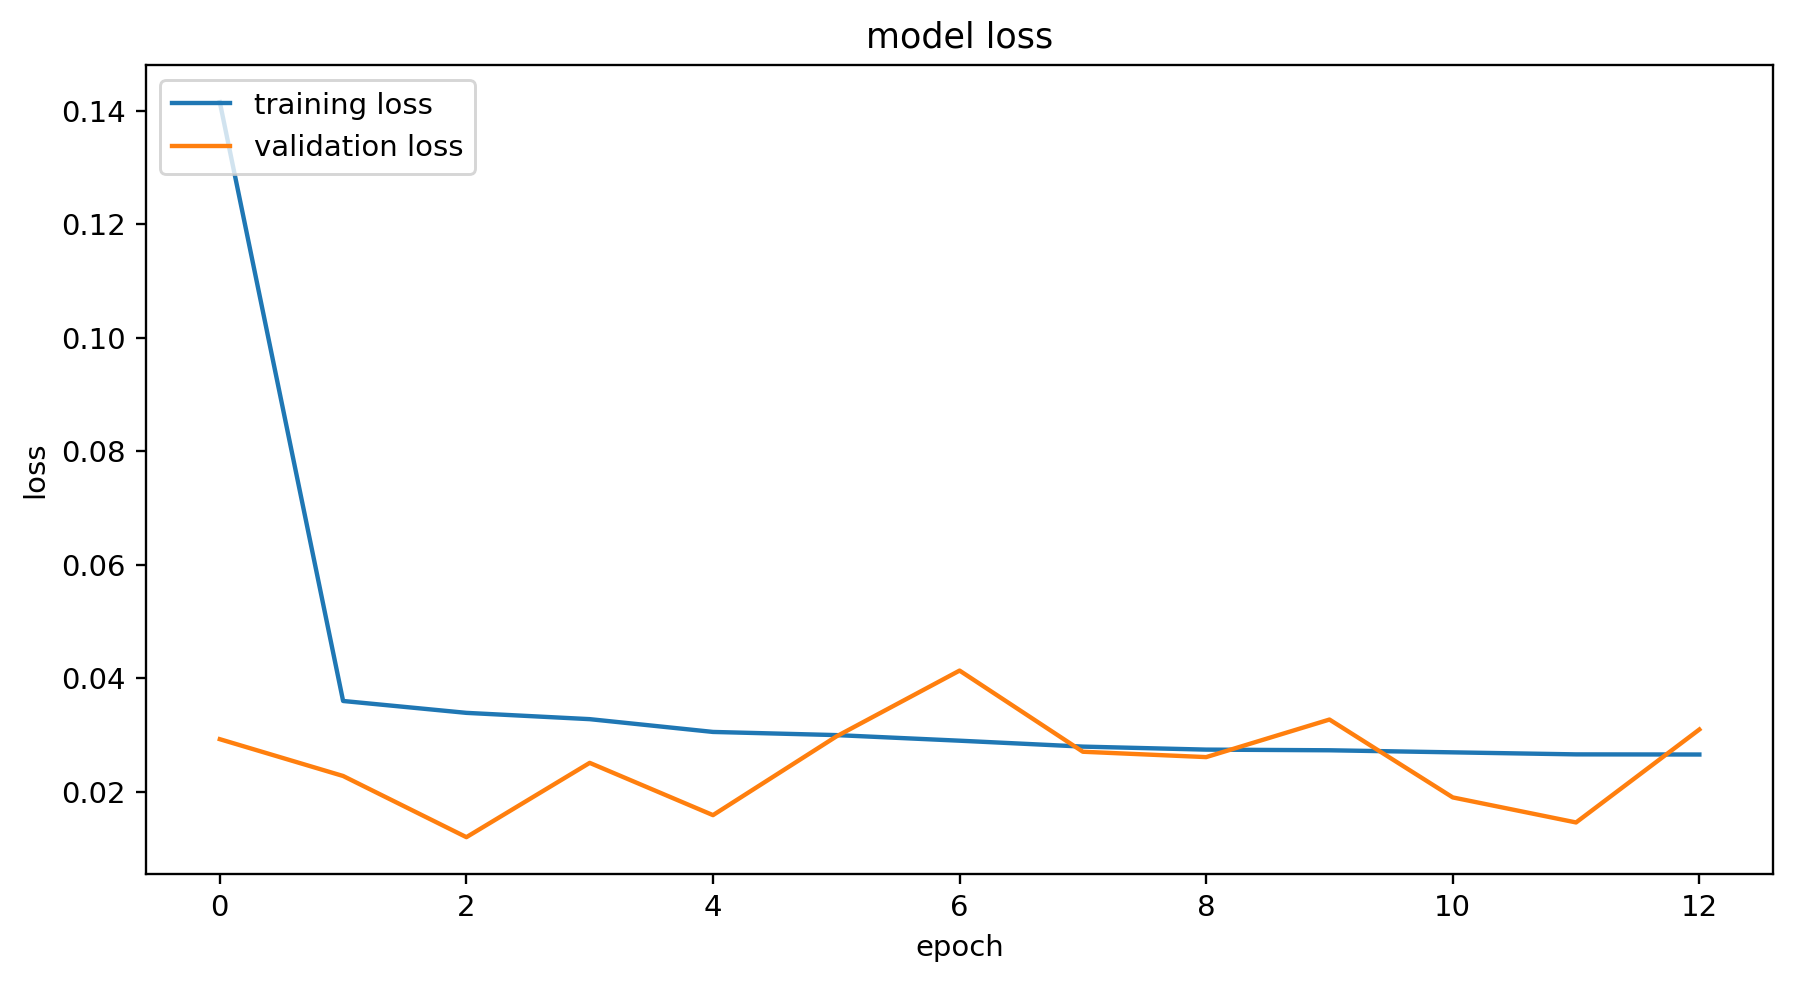

In [15]:
### Gráfica de comparación de model loss
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Ignorar advertencias del código.
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(10,5), dpi = 105)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training loss', 'validation loss'], loc='upper left')
plt.show()

Conclusiones:

- El modelo parece haber convergido hacia una solución razonable, ya que la pérdida de validación se estabiliza.

- Sin embargo, existe una clara evidencia de sobreajuste, lo que sugiere que el modelo podría no generalizar bien a nuevos datos.

Se organizan los datos para organizarse en un dataFrame

In [16]:
#x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(X_test, verbose=0)                        # Se realizan las predicciones
#print(yhat)

# Importanción de librería
from functools import reduce
Lista_predict = yhat.tolist()                                  # Se transforma el array en una nested list (lista dentro de listas)
prediccion = reduce(lambda x,y: x+y, Lista_predict)            # Luego se transforma en una lista de una sola dimensión


y_test = y_test.tolist()                                       # Se transforma el array en una nested list (lista dentro de listas)
y_test1 = reduce(lambda x,y: x+y, y_test)                      # Se transforma el array en una nested list (lista dentro de listas)

Se escalan los datos a su valor real

In [17]:
#Se vuelven a escalar los datos a su valor real para los datos de prueba
ytest_real = scaler.inverse_transform(y_test1)
ytest_real = ytest_real.tolist()
ytest_real1 = reduce(lambda x,y: x+y, ytest_real)

#Se vuelven a escalar los datos a su valor real para las predicciones

yreal_prediccion = scaler.inverse_transform(prediccion)
yreal_prediccion = yreal_prediccion.tolist()
yreal_prediccion1 = reduce(lambda x,y: x+y, yreal_prediccion)

Se muestran los datos comparados en un dataframe y en una gráfica con sus valores reales

In [18]:
# Se muestra una comparación de  los datos predichos y los reales  en un DataFrame


train_results = pd.DataFrame(data={'Train Predictions':yreal_prediccion1 , 'Actuals':ytest_real1})
train_results

,Train Predictions,Actuals
0,37533.739002,37760.28
1,37536.961830,37426.30
2,37318.264043,37421.87
3,37276.805233,37468.04
4,37304.214381,37445.35
...,...,...
15061,31211.206738,31552.81
15062,31510.692345,31364.09
15063,31387.429332,31236.65
15064,31242.042974,31096.75


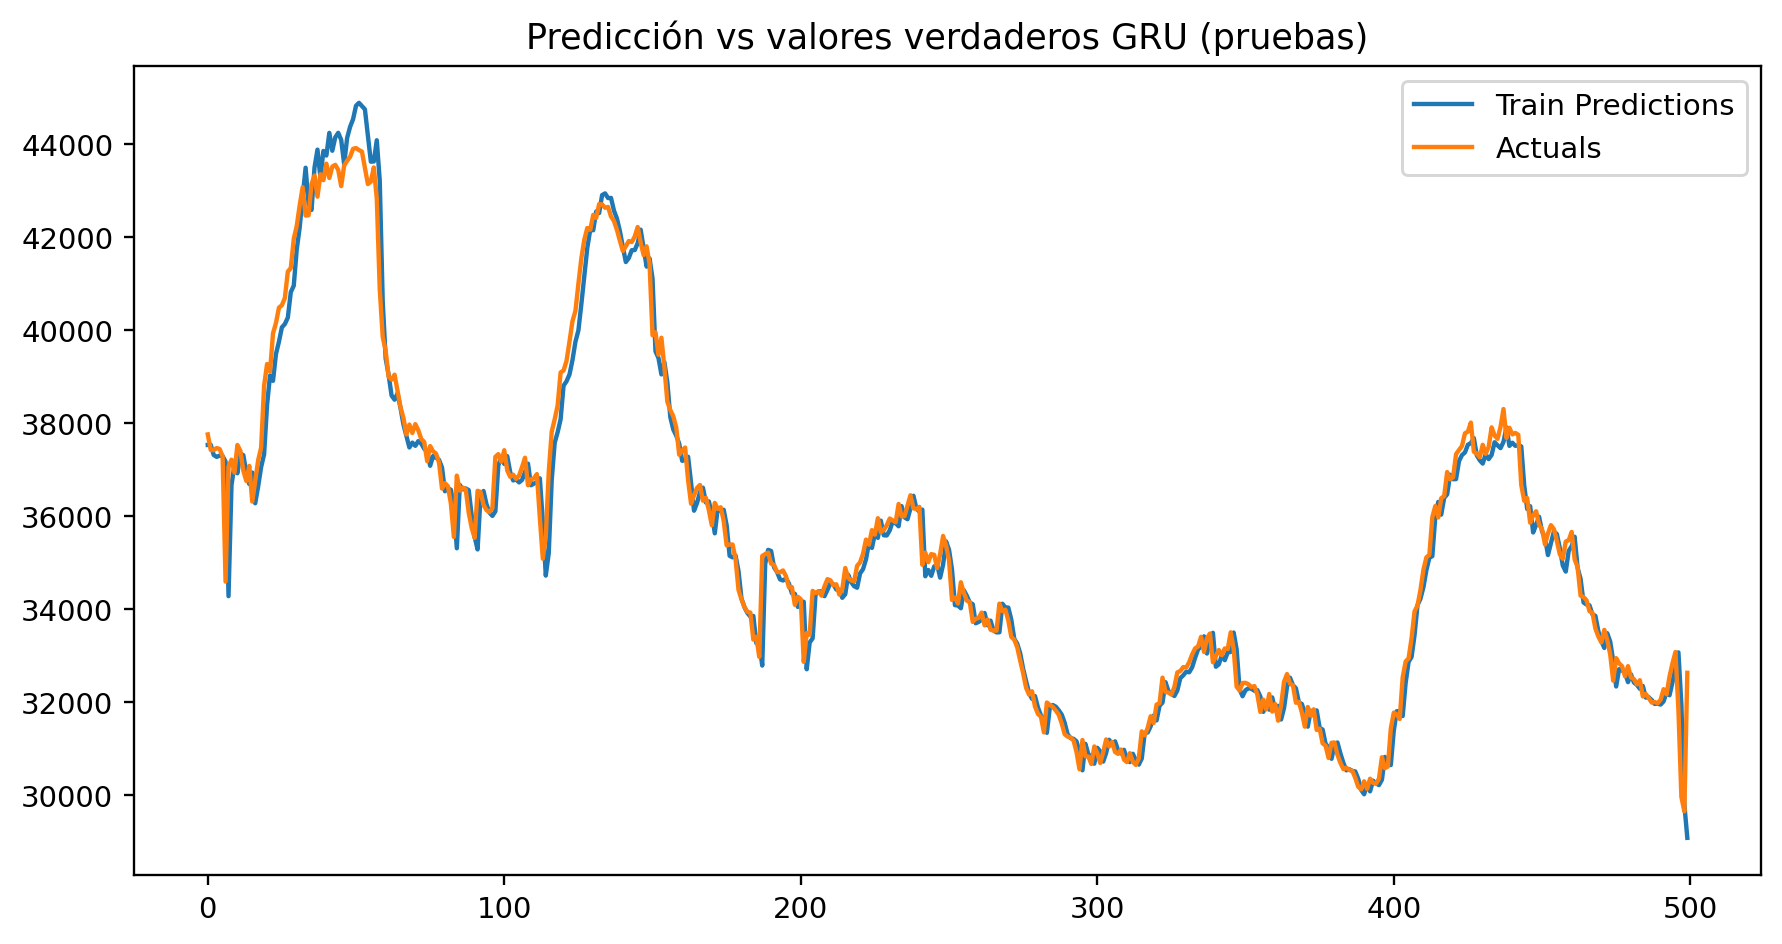

In [19]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Ignorar advertencias del código.
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(10,5), dpi = 105)
plt.plot(train_results["Train Predictions"][:500],label="Train Predictions")
plt.plot(train_results["Actuals"][:500],label="Actuals")
plt.title("Predicción vs valores verdaderos GRU (pruebas)")
plt.legend();

### Métricas de medición

mean_absolute_percentage_error calcula el error porcentual absoluto medio (MAPE, por sus siglas en inglés) entre los valores verdaderos (y_true) y los valores predichos (y_pred). El MAPE es una métrica de evaluación común para modelos de regresión

In [20]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [22]:
# Métricas de rendimiento
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error #Error absoluto, cuadrado, y cuadrado logarítmico.



print(f"Test Mean Squared Error: {mean_squared_error(y_test1, prediccion)}")
print(f"Test Mean Absolute Error: {mean_absolute_error(y_test1, prediccion)}")
#print(f"Test Mean squared log error: {mean_squared_log_error(y_test1, prediccion)}")
mape = mean_absolute_percentage_error(y_test1,prediccion)
print('Mean absolute percentage error (MAPE): %f' % mape)

Test Mean Squared Error: 0.0003116511378393569
Test Mean Absolute Error: 0.011864015416014725
Mean absolute percentage error (MAPE): 5.239207


# Modelo 2 LSTM Univariada

In [23]:
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

In [24]:
from keras import callbacks
from keras.callbacks import ModelCheckpoint
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')                   # Se entrena el modelo usando un optimizador llamado adam y que se basa en los mse
                                                              # o error cuadrático medio
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
model.fit(X_train,y_train, epochs=20, verbose=1, callbacks=[early_stopping], validation_split=0.2)             # Se entrena el modelo con la infromación del dataset usada para entrenamiento.


Epoch 1/20
1517/1517 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 0.0060 - val_loss: 3.3418e-04
Epoch 2/20
1517/1517 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - loss: 2.5530e-04 - val_loss: 2.7825e-04
Epoch 3/20
1517/1517 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - loss: 2.1780e-04 - val_loss: 2.9579e-04
Epoch 4/20
1517/1517 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 2.2423e-04 - val_loss: 2.6385e-04
Epoch 5/20
1517/1517 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - loss: 2.1611e-04 - val_loss: 2.6985e-04
Epoch 6/20
1517/1517 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 2.2394e-04 - val_loss: 2.5446e-04
Epoch 7/20
1517/1517 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 2.1438e-04 - val_loss: 2.6173e-04
Epoch 8/20
1517/1517 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - loss: 2.1248e-04 - val_loss: 2.8298e-04
Epoch 9/20
1517/1517 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 2.0703e-04 - val_loss: 2.9296e-04
Epoch 10/20
1517/1517 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - loss: 2.1065e-04 - val_loss: 2.5073e-04
Epoch 11/20
1517/1517 ━

Se escalan los datos a su valor real

In [26]:
#x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(X_test, verbose=0)                        # Se realizan las predicciones
#print(yhat)

# Importanción de librería
from functools import reduce
Lista_predict = yhat.tolist()                                  # Se transforma el array en una nested list (lista dentro de listas)
prediccion = reduce(lambda x,y: x+y, Lista_predict)            # Luego se transforma en una lista de una sola dimensión


In [27]:
yreal_prediccion = scaler.inverse_transform(Lista_predict)
yreal_prediccion = yreal_prediccion.tolist()
yreal_prediccion1 = reduce(lambda x,y: x+y, yreal_prediccion)

Se muestran los datos comparados en un dataframe y en una gráfica pero de forma escalada

In [28]:
# Se muestra una comparación de  los datos predichos y los reales  en un DataFrame


# Se muestra una comparación de  los datos predichos y los reales  en un DataFrame

y_test1_lstm = [item for sublist in y_test1 for item in sublist]
train_results = pd.DataFrame(data={'Train Predictions':yreal_prediccion1, 'Actuals':ytest_real1})
train_results

,Train Predictions,Actuals
0,37890.432464,37760.28
1,37882.536231,37426.30
2,37535.526358,37421.87
3,37473.166732,37468.04
4,37498.470621,37445.35
...,...,...
15061,31206.291698,31552.81
15062,31502.098386,31364.09
15063,31355.286749,31236.65
15064,31244.911654,31096.75


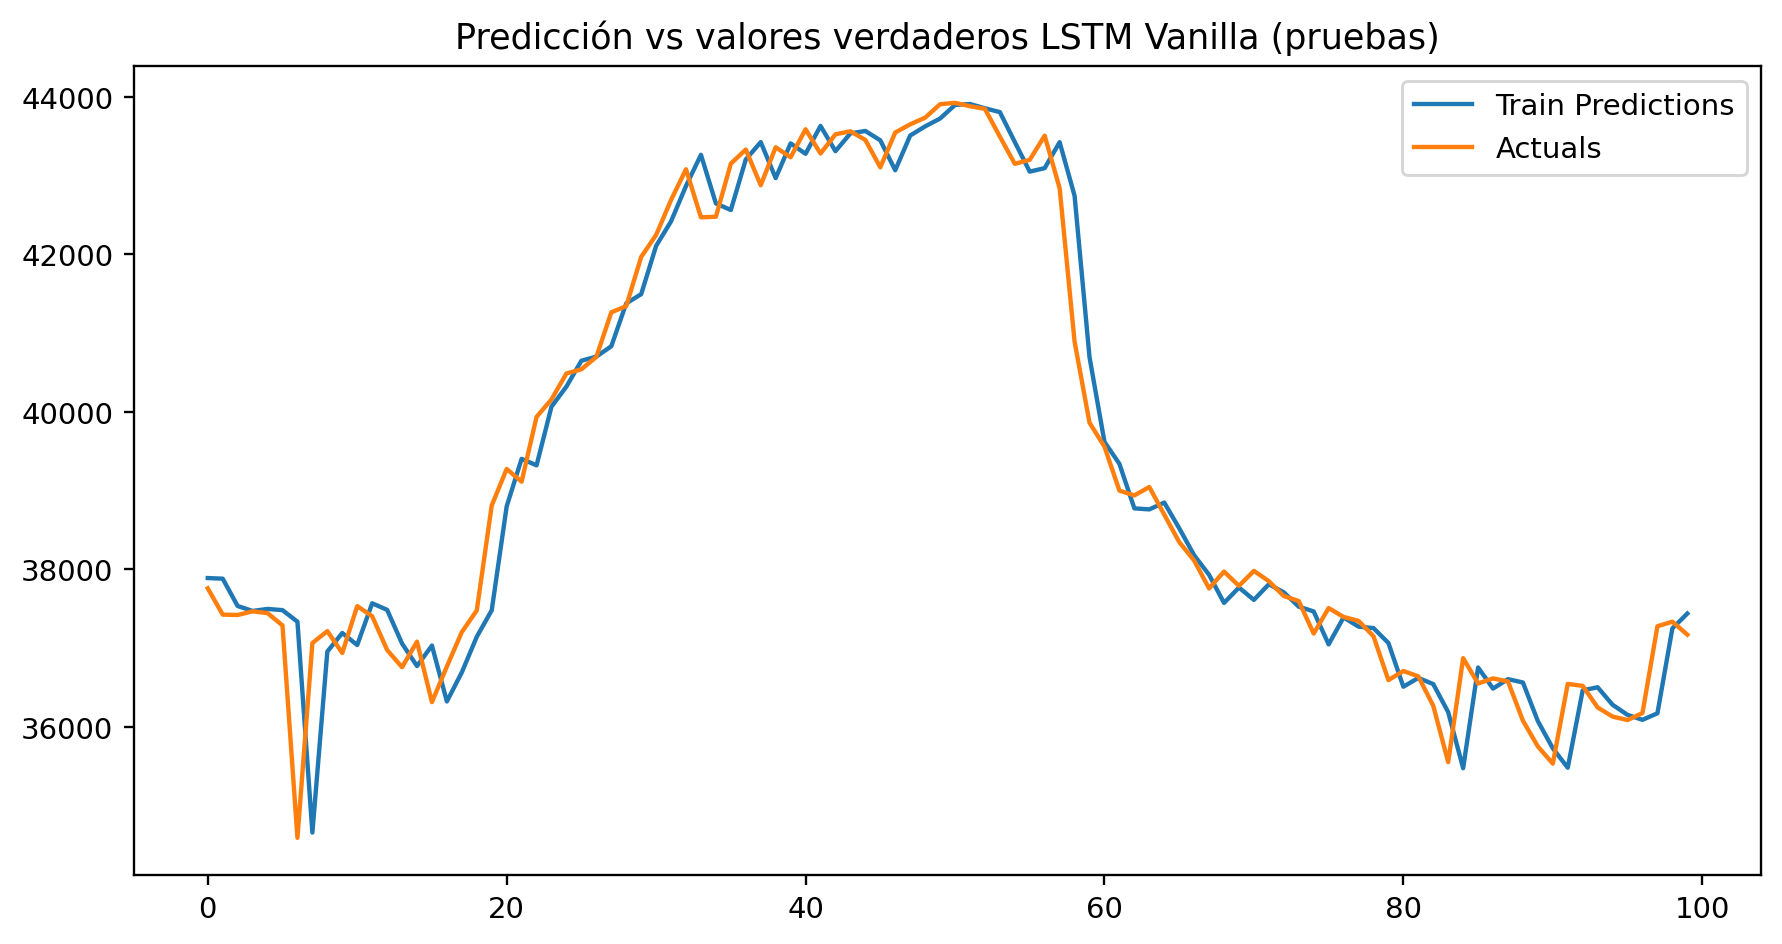

In [29]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Ignorar advertencias del código.
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(10,5), dpi = 105)
plt.plot(train_results["Train Predictions"][:100],label="Train Predictions")
plt.plot(train_results["Actuals"][:100],label="Actuals")
plt.title("Predicción vs valores verdaderos LSTM Vanilla (pruebas)")
plt.legend();

En general, el modelo LSTM Vanilla es capaz de realizar predicciones que siguen de cerca los valores reales, capturando el patrón general de la serie de tiempo. Aunque existen algunos puntos con pequeñas desviaciones, el rendimiento del modelo parece adecuado. El siguiente paso podría ser un ajuste fino de los hiperparámetros o el uso de técnicas de regularización para mejorar aún más la precisión

In [30]:
# Métricas de rendimiento
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error #Error absoluto, cuadrado, y cuadrado logarítmico.



print(f"Test Mean Squared Error: {mean_squared_error(y_test1_lstm, prediccion)}")
print(f"Test Mean Absolute Error: {mean_absolute_error(y_test1_lstm, prediccion)}")
print(f"Test Mean squared log error: {mean_squared_log_error(y_test1_lstm, prediccion)}")
mape = mean_absolute_percentage_error(y_test1_lstm,prediccion)
print('Mean absolute percentage error (MAPE): %f' % mape)

Test Mean Squared Error: 0.00021116164498355243
Test Mean Absolute Error: 0.009746186105093054
Test Mean squared log error: 0.00012997512956121156
Mean absolute percentage error (MAPE): 4.040919


Estos resultados indican que el modelo LSTM Vanilla tiene un excelente rendimiento en esta tarea de predicción de series temporales. Los errores en cada métrica son bajos, lo que indica tanto precisión en la magnitud de las predicciones como una buena representación de los patrones de la serie temporal.

Si bien los resultados son buenos, algunas posibles mejoras podrían incluir:

Ajuste de hiperparámetros para reducir aún más el error, especialmente si el modelo se va a aplicar en datos nuevos.
Pruebas con otras arquitecturas, como modelos GRU o LSTM multicapa, para ver si se pueden obtener aún mejores resultados.
En general, un MAPE de 4.04% y errores absolutos tan bajos son indicadores de que el modelo está capturando bien la dinámica de la serie temporal.